In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import os
from os import walk

In [2]:
import tensorflow as tf
tf.random.set_seed(0)
tf.keras.backend.clear_session()


In [59]:
classes = {"buildings":0,"forest":1,"glacier":2, "mountain":3, "sea":4, "street":5}
dir_pred = 'E:\Machine Learning\cep\seg_pred\seg_pred'
dir_test = 'E:\Machine Learning\cep\seg_test\seg_test'
dir_train =  'E:\Machine Learning\cep\seg_train\seg_train'

In [60]:
# read in the names of the images in the prediction set
(dirpath_pred, dirnames_pred, fnames_pred) = next(walk(dir_pred))
print("Size of the prediction set is {}".format(len(fnames_pred)))

Size of the prediction set is 7301


In [61]:
def read_image_names_class(dpath):
    fnames = {}
    dirnames = []  # Initialize dirnames outside the loop

    for root, subdirs, files in os.walk(dpath):
        for d in subdirs:
            _, _, temp = next(walk(os.path.join(dpath, d)))
            fnames[classes[d]] = temp
            dirnames.append(d)

    return dirnames, fnames

def check_class_imbalance(fnames):
    count = 0
    class_summary = {}
    for key,value in fnames.items():
        count = count + len(value)
        class_summary[key] = len(value)
        
    summary = pd.DataFrame.from_dict(class_summary, orient='index', columns=["Count"])  
    summary['CumCount'] = np.cumsum(summary['Count']) 
    summary['Class'] = summary.index
    summary['Class'] = summary['Class'].apply(class_from_key)
    
    return summary

def class_from_key(x):
    for key, value in classes.items():
        if x == value:
            return key
        
# def sample_images_from_class(nsample, classname, path, fnames):
#     sind = np.random.random_integers(1,len(fnames[classes[classname]]),nsample)
#     spath = [os.path.join(path, classname, fnames[classes[classname]][i]) for i in sind]
    
#     return spath

def sample_images_from_class(nsample, classname, path, fnames):
    if classes[classname] in fnames:
        sind = np.random.randint(0, len(fnames[classes[classname]]), nsample)
        spath = [os.path.join(path, classname, fnames[classes[classname]][i]) for i in sind]
        return spath
    else:
        print(f"Class {classname} not found in fnames dictionary.")
        return []

def plot_sampled_images(path, fnames):
    nsample = 3
    ncols = len(classes)
    
    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))
    
    for i,cl in enumerate(classes.keys()):
        sp = sample_images_from_class(nsample, cl, path, fnames)
        for j,spj in enumerate(sp):            
            img = mpimg.imread(spj)
            ax[j,i].imshow(img)
            ax[j,i].axis('off')
            ax[j,i].set_title(cl)   
            
def sample_prediction_images(path, fnames, nsample):
    sind = np.random.random_integers(1,len(fnames), nsample)
    spj = []
    for sp in sind:
        spj.append(os.path.join(path, fnames[sp]))
    
    return spj
    
def plot_sampled_prediction_images(path, fnames):    
    nsample = 3
    ncols = len(classes)
    
    fig, ax = plt.subplots(nsample, ncols, figsize=(20, 3*nsample))
    sind = np.random.random_integers(1,len(fnames), nsample*ncols)
    
    axs = ax.ravel()
    for i, sp in enumerate(sind):
        spj = os.path.join(path, fnames[sp])
        img = mpimg.imread(spj)
        axs[i].imshow(img)
        axs[i].axis('off')
    
def get_true_pred(model, ds):
    y = model.predict(ds)

    ytrue = []
    ypred = []

    ypred.append(np.argmax(y,axis=1))
    for img, lbl in ds:
        for l in lbl:
            ytrue.append(np.argmax(l.numpy()))    
    
    return ytrue, ypred

def plot_confMat(ytrue, ypred):
    cm = confusion_matrix(y_true = ytrue,y_pred = ypred[0])
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[class_from_key(x) for x in range(6)])
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    cmd.plot(include_values=True, cmap = plt.cm.Blues, ax=ax)

    plt.title("Accuracy score is {:.2f}".format(accuracy_score(y_true = ytrue,y_pred = ypred[0])))
    
def read_prepare_image_predict(fpath, mod):
    img = tf.keras.preprocessing.image.load_img(fpath, grayscale=False, color_mode='rgb')
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    ax1.imshow(img)
    ax1.axis('off')
    
    parr = tf.keras.preprocessing.image.img_to_array(img)    
    tparr = tf.expand_dims(parr, axis=0)
    
    pred = mod.predict(tparr)
    y = [p for p in pred[0]]
    x = [class_from_key(i) for i in range(6)]
    
    sns.barplot(x=x,y=y,ax=ax2)
    
    return pred

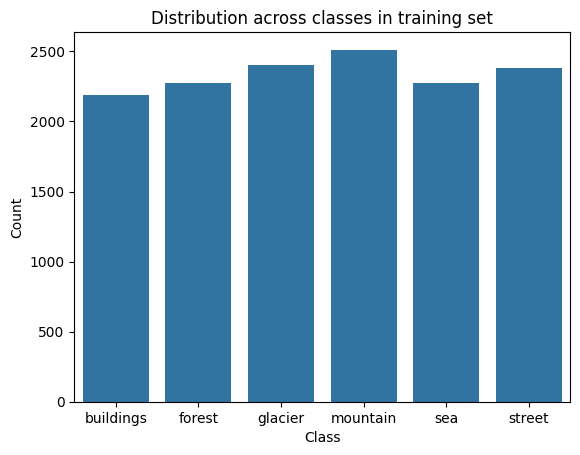

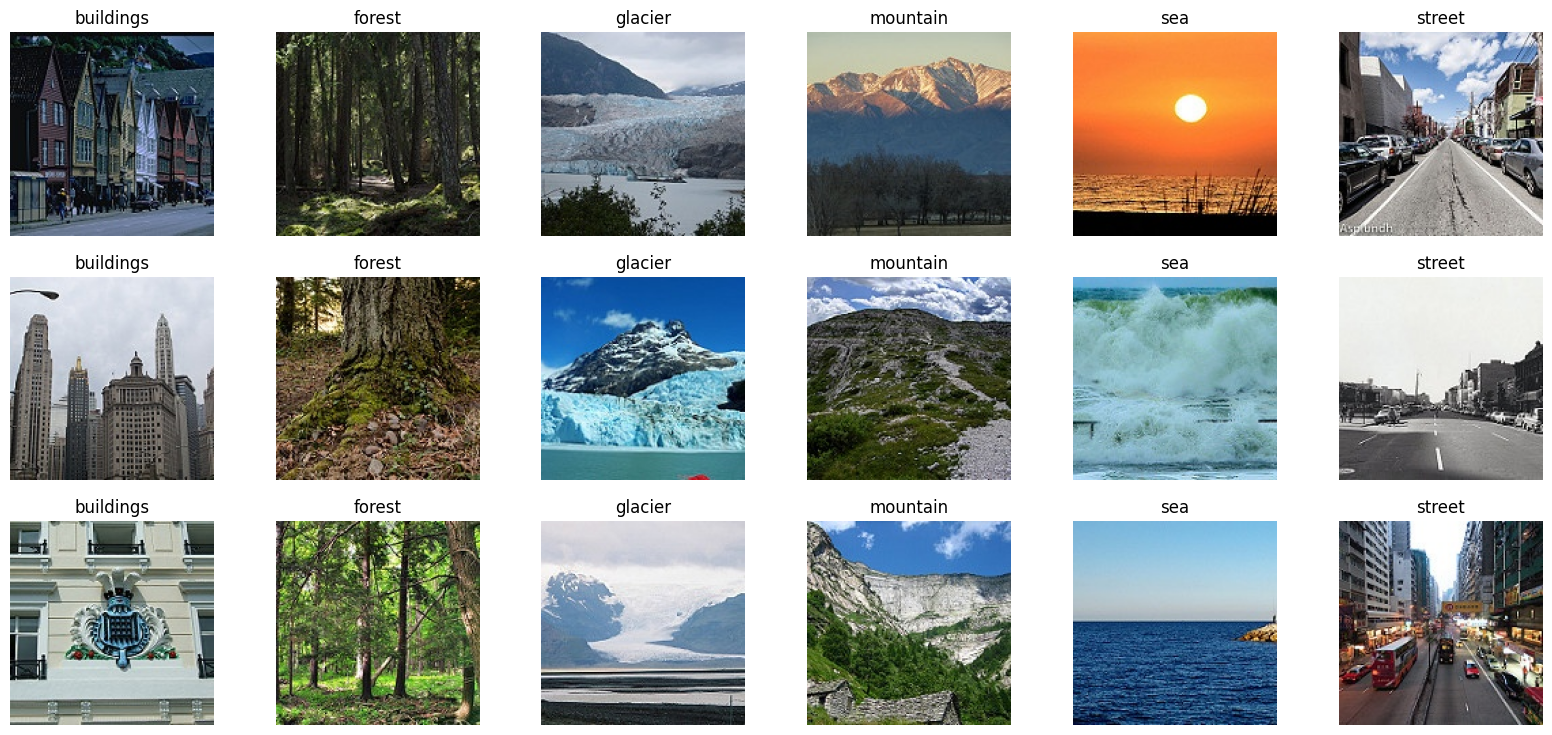

In [62]:
dirnames_train, fnames_train = read_image_names_class(dir_train)
train_summary = check_class_imbalance(fnames_train)
train_summary.head(10)
sns.barplot(data=train_summary, x = 'Class', y='Count').set_title("Distribution across classes in training set")
plot_sampled_images(dir_train, fnames_train)

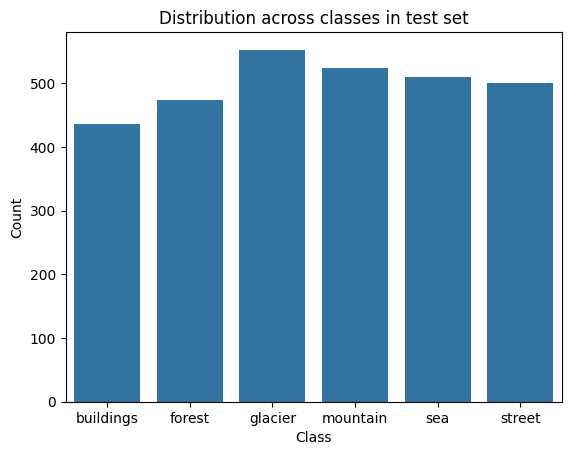

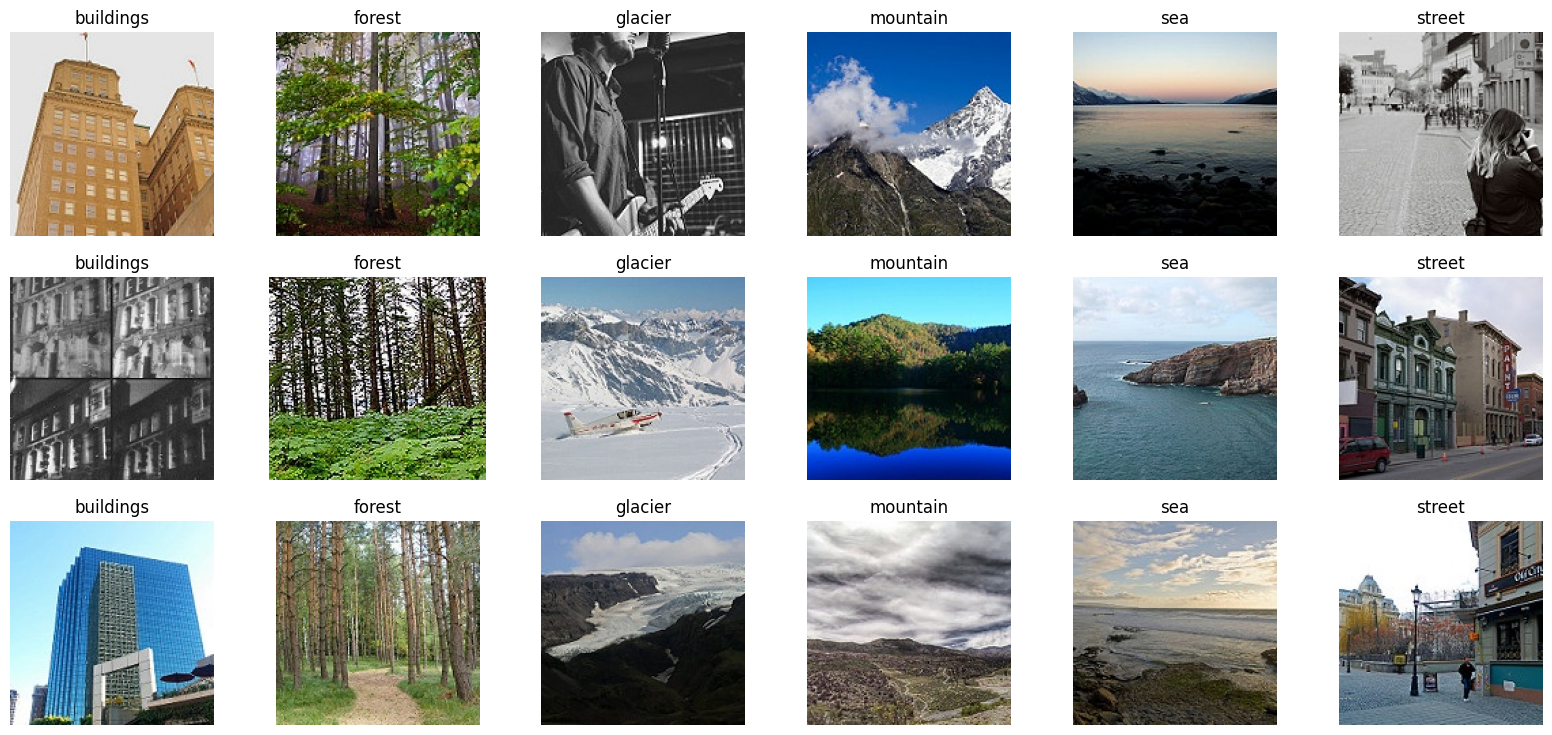

In [63]:
dirnames_test, fnames_test = read_image_names_class(dir_test)
test_summary = check_class_imbalance(fnames_test)
test_summary.head(10)

sns.barplot(data=test_summary, x = 'Class', y='Count').set_title("Distribution across classes in test set")

plot_sampled_images(dir_test, fnames_test)

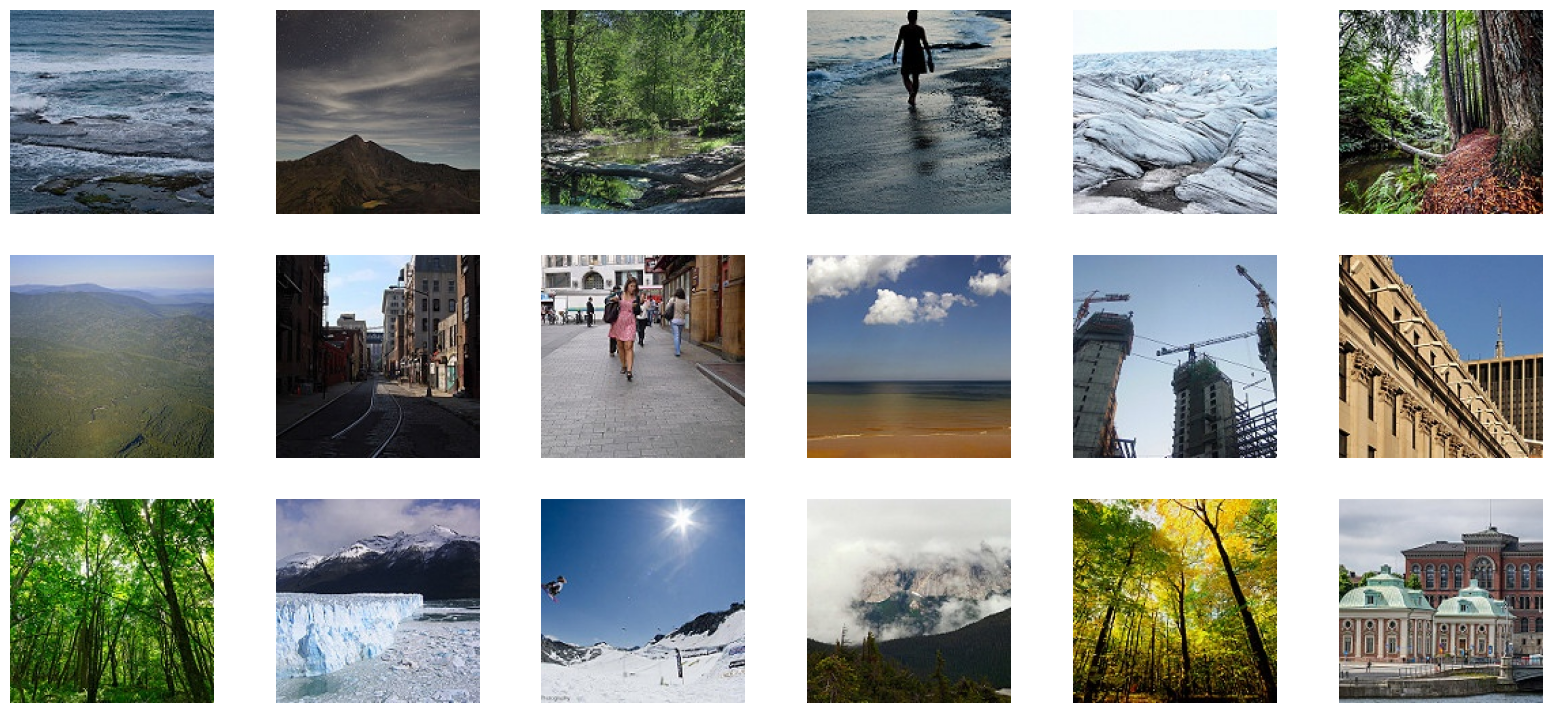

In [57]:
plot_sampled_prediction_images(dir_pred, fnames_pred)

In [64]:
batch = 32
shuff = True
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dir_train,
                                                               validation_split=0.2,  subset="training",
                                                               seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= shuff, label_mode='categorical')
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dir_train,
                                                               validation_split=0.2,  subset="validation",
                                                               seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= shuff, label_mode='categorical')


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [65]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [66]:
train_model = False

In [67]:
if train_model:
    mod = tf.keras.models.Sequential([    
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape = (150,150,3)),
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.05),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.3), width_factor=(0.1,0.3)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(filters=12, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),    
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=12, kernel_size=(1,1), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),    
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),   
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),      
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),

        tf.keras.layers.Dense(units=256, activation='relu'),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=6, activation='softmax')
            ])
    
    mets = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), 
        tf.metrics.TrueNegatives(), tf.metrics.TruePositives(), tf.metrics.FalseNegatives(), tf.metrics.FalsePositives()]
    mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])
    
    earlystop = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=1e-3, restore_best_weights=True)
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-7)

    # traindat_aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.2, height_shift_range=0.2, 
    #                                                           brightness_range=(-2.,2.), zoom_range=0.2, horizontal_flip=True, 
    #                                                           rescale=1./255, validation_split=0.2)
    # testdat_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


    # train_ds = traindat_aug.flow_from_directory(dir_train, target_size=(150,150), batch_size=batch, class_mode='categorical', subset="training")
    # valid_ds = traindat_aug.flow_from_directory(dir_train, target_size=(150,150), batch_size=batch, class_mode='categorical', subset="validation")
    # test_ds = testdat_aug.flow_from_directory(dir_test, target_size=(150,150), batch_size=batch, class_mode='categorical')

    # traindat_aug.fit(train_ds)

In [86]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming classes are defined as before
classes = {"buildings": 0, "forest": 1, "glacier": 2, "mountain": 3, "sea": 4, "street": 5}

# Assuming image size is 150x150 and 3 channels (RGB)
input_shape = (150, 150, 3)

# Build the model
model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=input_shape),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')  # Adjust output units based on the number of classes
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 batch_normalization_4 (Bat  (None, 150, 150, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 16)        2320      
                                                                 
 batch_normalization_5 (Bat  (None, 75, 75, 16)       

In [87]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming classes are defined as before
classes = {"buildings": 0, "forest": 1, "glacier": 2, "mountain": 3, "sea": 4, "street": 5}

# Assuming image size is 150x150 and 3 channels (RGB)
input_shape = (150, 150, 3)

# Set the number of filters in convolutional layers to achieve 208 non-trainable parameters
num_filters_conv1 = 16
num_filters_conv2 = 12
num_filters_conv3 = 12
num_filters_conv4 = 16
num_filters_conv5 = 16
num_filters_conv6 = 16

# Build the model
model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=input_shape),
    layers.Conv2D(num_filters_conv1, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(num_filters_conv2, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(num_filters_conv3, (1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(num_filters_conv4, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(num_filters_conv5, (5, 5), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(num_filters_conv6, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(units=256, activation='relu'),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=len(classes), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 batch_normalization_6 (Bat  (None, 150, 150, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 75, 75, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 12)        1740      
                                                                 
 batch_normalization_7 (Bat  (None, 75, 75, 12)       

In [88]:
if train_model:
    for key in hist.history.keys():
        plt.plot(hist.history[key],label=key)
    plt.legend()
    # plt.ylim([0,1])

In [89]:
if train_model:
    model_json = model.to_json()
    with open("CNN_Intel.json","w") as json_file:
        json_file.write(model_json)

Found 14034 files belonging to 6 classes.
439/439 [==============================] - 76s 172ms/step - loss: 1.7918 - accuracy: 0.1486


[1.7918452024459839, 0.1486390233039856]

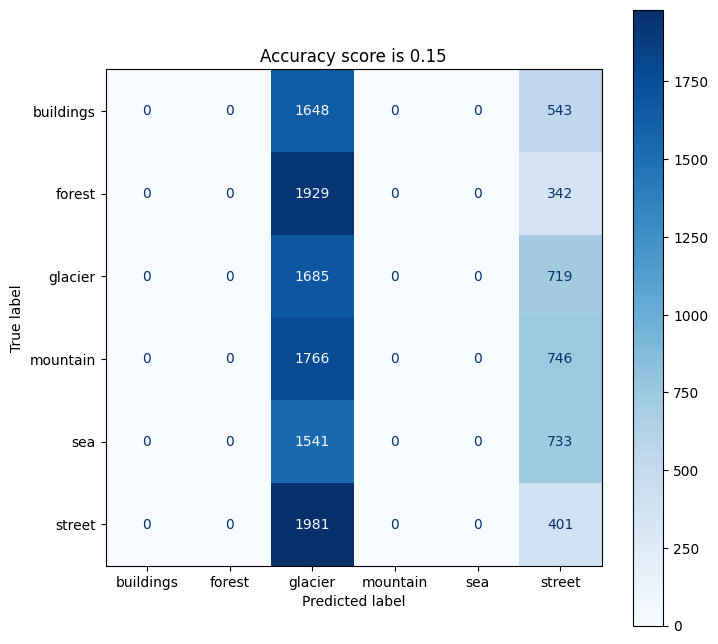

In [90]:
train_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_train,                                                   
                                                               seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= False, label_mode='categorical')
y_true, y_pred = get_true_pred(model, train_ds1)
plot_confMat(y_true, y_pred)

model.evaluate(train_ds1)

Found 3000 files belonging to 6 classes.
94/94 [==============================] - 16s 174ms/step - loss: 1.7915 - accuracy: 0.1573


[1.791487455368042, 0.15733332931995392]

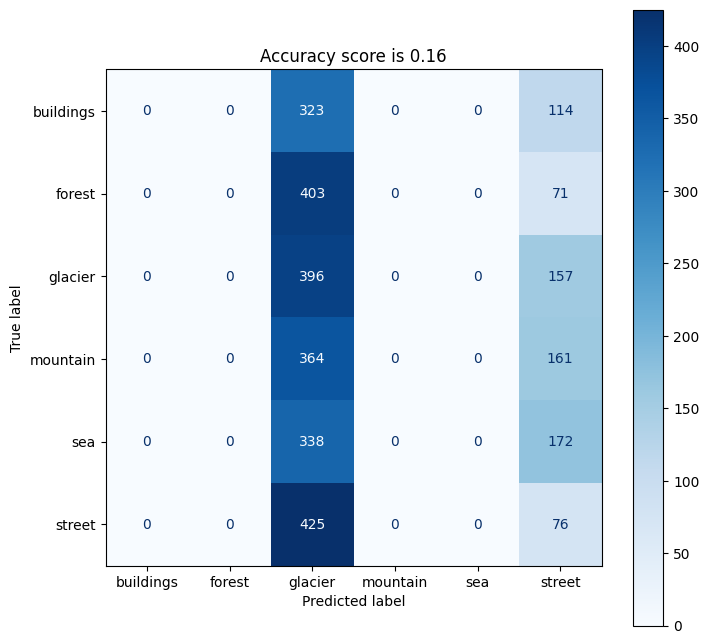

In [93]:
test_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_test, seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= False, label_mode='categorical')
# y_test = mod.predict(test_ds)
# tf.keras.utils.to_categorical(np.argmax(y_test,axis=1))
y_true, y_pred = get_true_pred(model, test_ds1)
plot_confMat(y_true, y_pred)

model.evaluate(test_ds1)

1/1 [==============================] - 0s 43ms/step


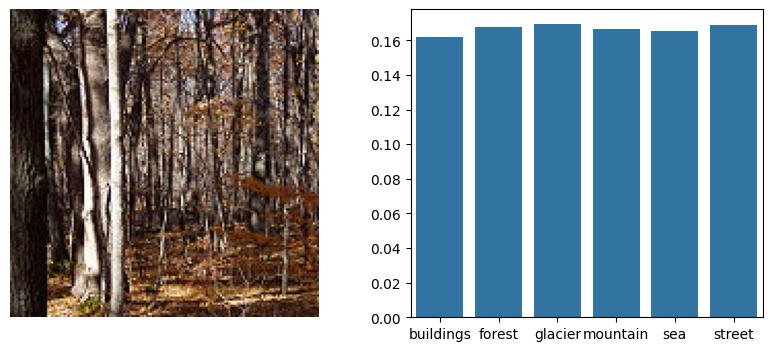

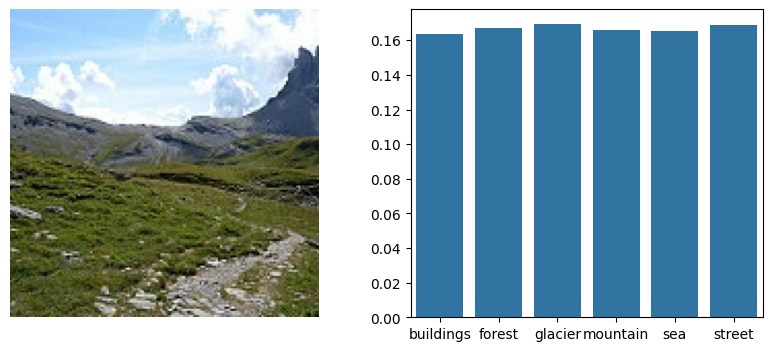

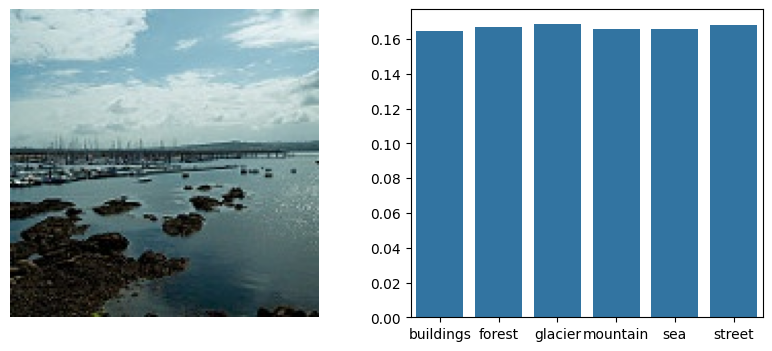

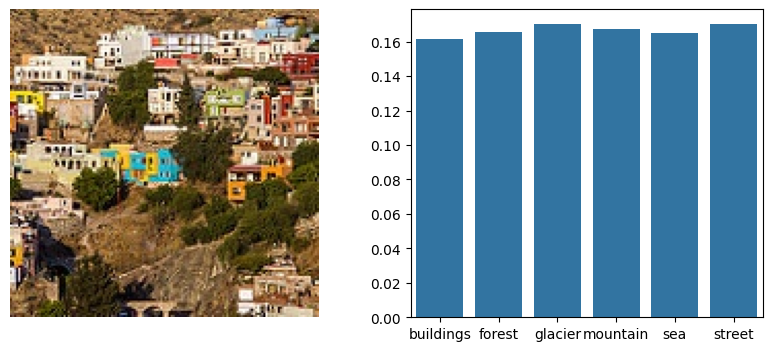

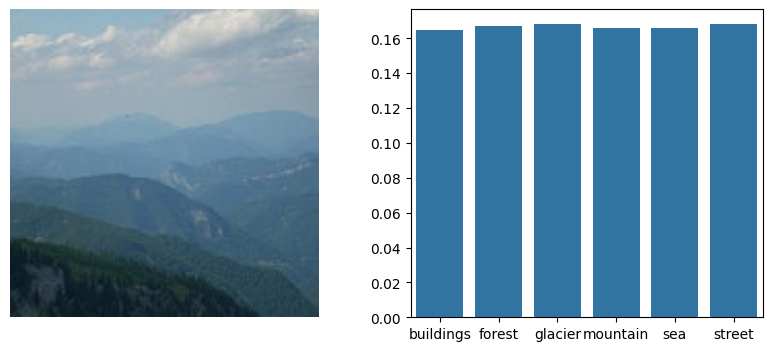

In [95]:
sp = sample_prediction_images(dir_pred, fnames_pred, 5)
for spj in sp:
    read_prepare_image_predict(spj,model)

In [96]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming classes are defined as before
classes = {"buildings": 0, "forest": 1, "glacier": 2, "mountain": 3, "sea": 4, "street": 5}

# Assuming image size is 150x150 and 3 channels (RGB)
input_shape = (150, 150, 3)

# Build the model
model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=input_shape),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')  # Adjust output units based on the number of classes
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 batch_normalization_12 (Ba  (None, 150, 150, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 75, 75, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 batch_normalization_13 (Ba  (None, 75, 75, 32)       

Found 14034 files belonging to 6 classes.
439/439 [==============================] - 100s 227ms/step - loss: 1.7931 - accuracy: 0.1967


[1.7930700778961182, 0.19666524231433868]

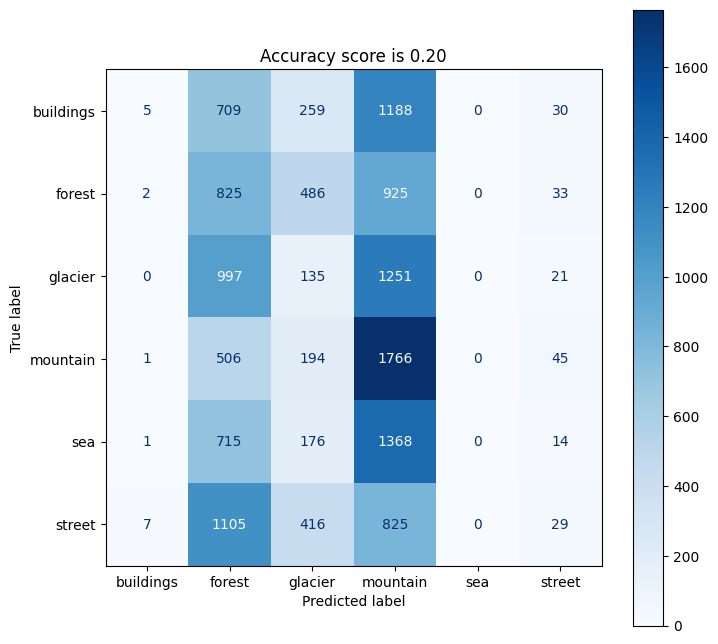

In [98]:
train_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_train,                                                   
                                                               seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= False, label_mode='categorical')
y_true, y_pred = get_true_pred(model, train_ds1)
plot_confMat(y_true, y_pred)

model.evaluate(train_ds1)

Found 3000 files belonging to 6 classes.
94/94 [==============================] - 21s 221ms/step - loss: 1.7941 - accuracy: 0.2007


[1.7941339015960693, 0.2006666660308838]

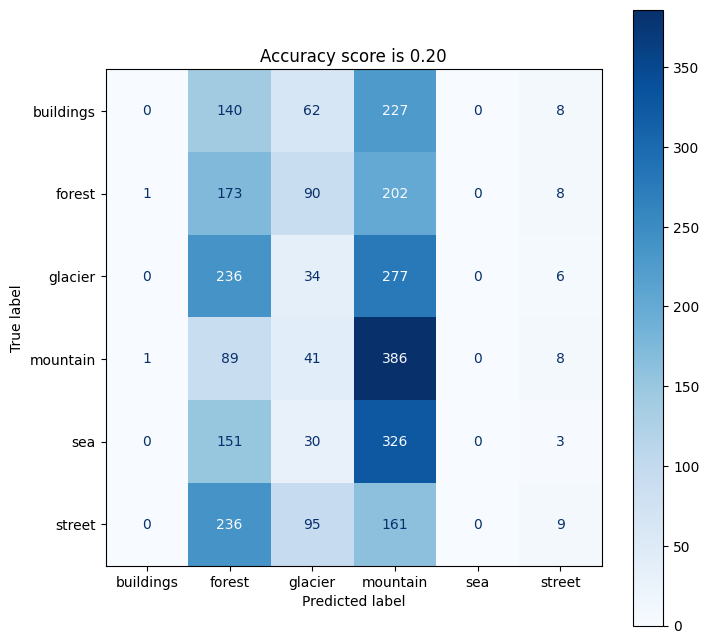

In [99]:
test_ds1 = tf.keras.preprocessing.image_dataset_from_directory(dir_test, seed=0,  image_size=(150, 150),
                                                               batch_size=batch, shuffle= False, label_mode='categorical')
# y_test = mod.predict(test_ds)
# tf.keras.utils.to_categorical(np.argmax(y_test,axis=1))
y_true, y_pred = get_true_pred(model, test_ds1)
plot_confMat(y_true, y_pred)

model.evaluate(test_ds1)

1/1 [==============================] - 0s 48ms/step


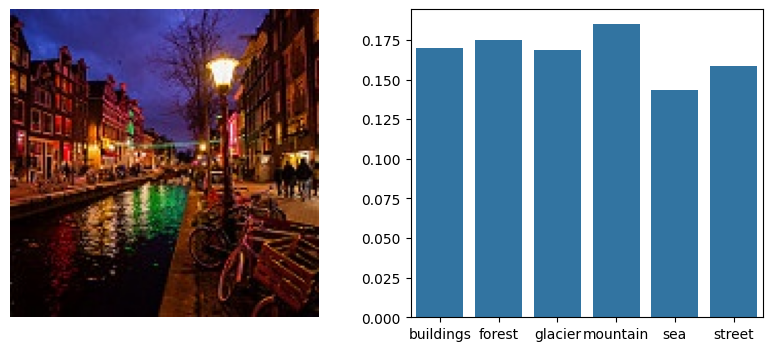

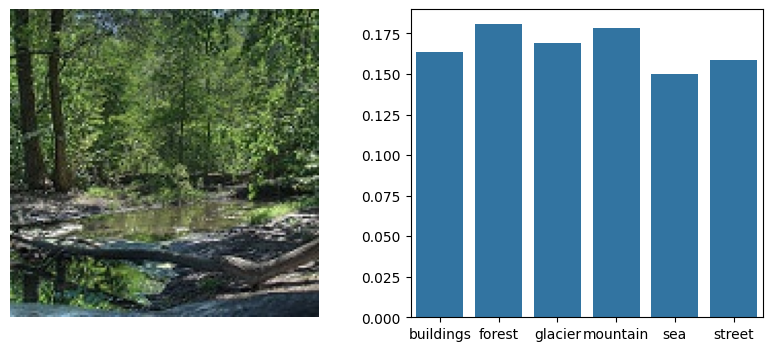

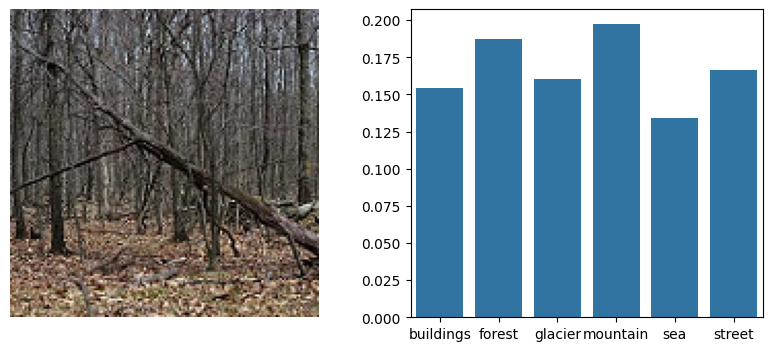

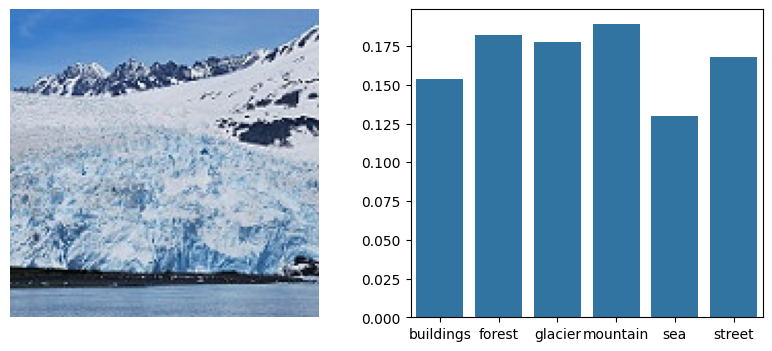

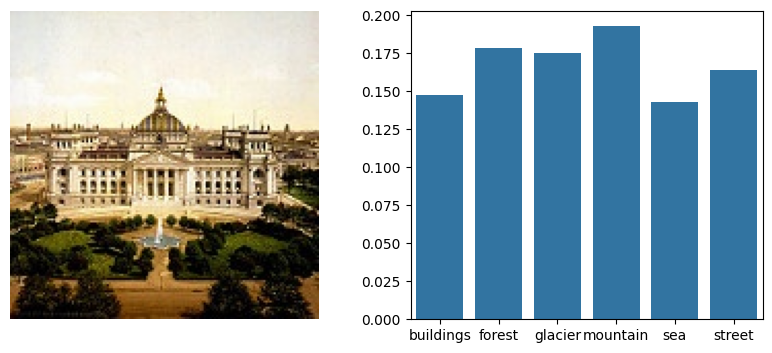

In [102]:
sp = sample_prediction_images(dir_pred, fnames_pred, 5)
for spj in sp:
    read_prepare_image_predict(spj,model)

In [104]:
!git clone https://github.com/wajideveloper/cnn.git

Cloning into 'cnn'...


In [107]:
# Clone the repository
# !git clone https://github.com/your-username/your-repository.git
!cp Wajid(347417) CNN ASSign3.ipynb https://github.com/wajideveloper/cnn/
# Move the Jupyter Notebook file to the local repository
# !mv Wajid(347417) CNN ASSign3.ipynb cnn/



'cp' is not recognized as an internal or external command,
operable program or batch file.


In [108]:
# Navigate to the local repository directory
%cd 

# Initialize a new Git repository (if not already initialized)
!git init



Initialized empty Git repository in C:/Users/Choice/.git/


In [109]:
# Add the Jupyter Notebook file
!git add Wajid(347417) CNN ASSign3.ipynb



fatal: pathspec 'Wajid(347417)' did not match any files
